In [1]:
paths = [
    "/usr/local/cython/gtsam",
    "/home/mikhail/research/gpmp2/cmake-build-release/cython/gpmp2",
    "/home/mikhail/research/gpmp2/gpmp2_python"
]
import sys
for path in paths:
    if path not in sys.path:
        sys.path.append(path)

In [2]:
import numpy as np
from gtsam import *
from gpmp2 import *
import matplotlib.pyplot as plt
import gpmp2
from gpmp2_python.datasets.generate2Ddataset import generate2Ddataset, Dataset
from gpmp2_python.robots.generateArm import generateArm
from gpmp2_python.utils.plot_utils import *
from gpmp2_python.utils.signedDistanceField2D import signedDistanceField2D
import cv2

In [5]:
def map_image_from_point(points, dataset):
    x = (points[:, 0] - dataset.origin_x) / dataset.cell_size 
    y = (points[:, 1] - dataset.origin_y) / dataset.cell_size 
    return np.stack([x, y], axis=1).astype(np.int32)

def draw_poly(points, dataset):
    points = map_image_from_point(points, dataset)
    dataset.map = cv2.fillConvexPoly(dataset.map, points, [255, 255, 255])

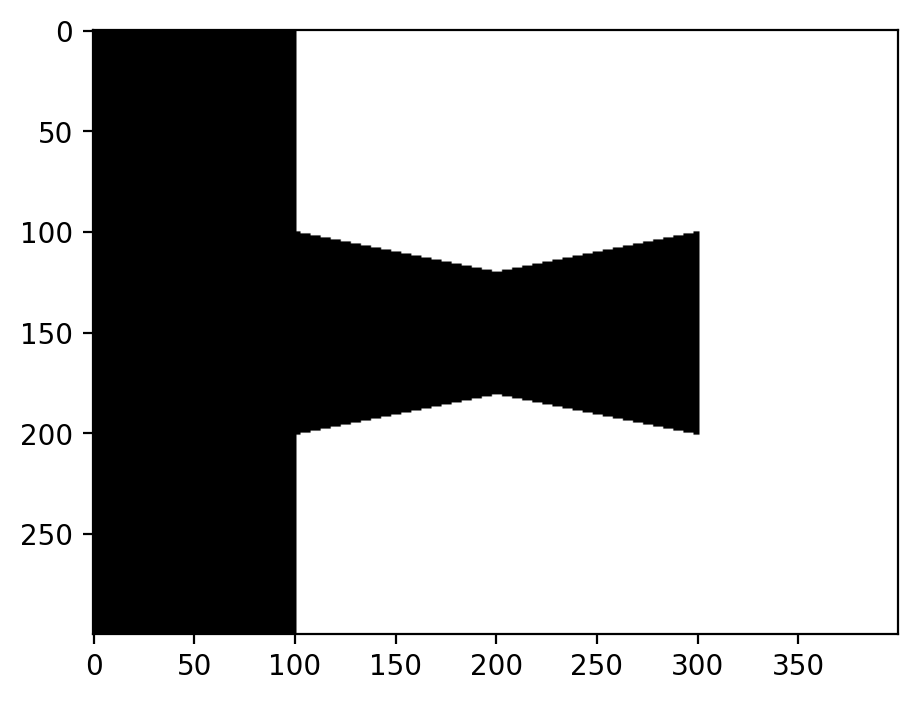

In [83]:
plt.figure(dpi=200)



dataset = Dataset()
dataset.cols = 400  # x
dataset.rows = 300  # y
dataset.origin_x = -20
dataset.origin_y = -10
dataset.cell_size = 0.1

grid_corner_x = dataset.origin_x + (dataset.cols - 1) * dataset.cell_size
grid_corner_y = dataset.origin_y + (dataset.rows - 1) * dataset.cell_size
    
# axis = plt.gca()
# axis.axis("equal")
# axis.axis(
#     [
#         dataset.origin_x - dataset.cell_size / 2,
#         grid_corner_x + dataset.cell_size / 2,
#         dataset.origin_y - dataset.cell_size / 2,
#         grid_corner_y + dataset.cell_size / 2,
#     ]
# )

dataset.map = np.zeros((dataset.rows, dataset.cols))
draw_poly(np.array([[-20, -10], [-20, 20], [-10, 20], [-10, -10]]), dataset)
draw_poly(np.array([[-10, 10], [0, 8], [0, 2], [-10, 0]]), dataset)
draw_poly(np.array([[0, 8], [0, 2], [10, 0], [10, 10]]), dataset)
plt.imshow(255 - dataset.map, cmap="gray")

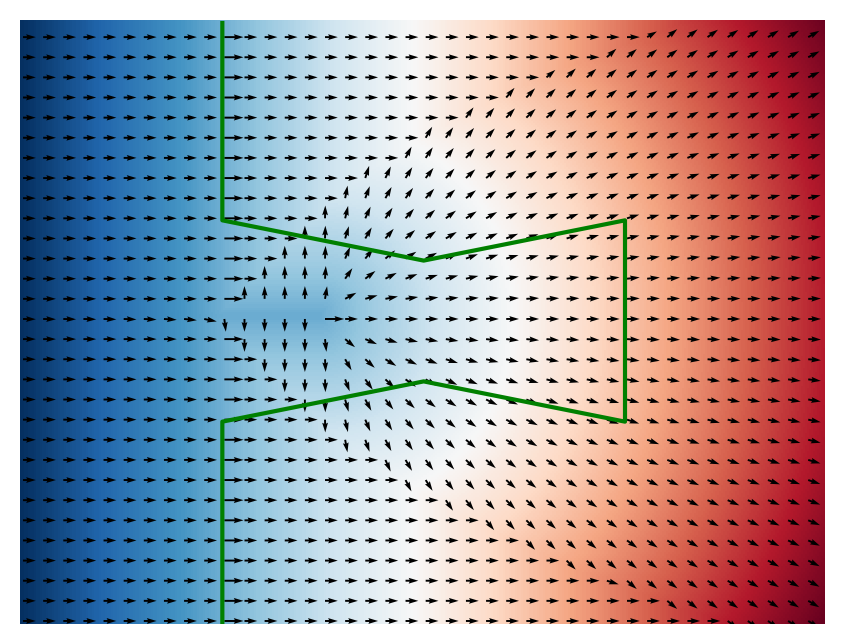

In [103]:
# dataset = generate2Ddataset("MultiObstacleDataset")
rows = dataset.rows
cols = dataset.cols
cell_size = dataset.cell_size
origin_point2 = Point2(dataset.origin_x, dataset.origin_y)

# Signed Distance field
field = signedDistanceField2D(dataset.map, cell_size)
sdf = PlanarSDF(origin_point2, cell_size, field)

x1 = dataset.origin_x
x2 = dataset.origin_x + (dataset.cols - 1) * dataset.cell_size
y1 = dataset.origin_y
y2 = dataset.origin_y + (dataset.rows - 1) * dataset.cell_size

x, y = np.meshgrid(np.linspace(x1, x2, dataset.cols), np.linspace(y1, y2, dataset.rows))

plt.figure(dpi=200)
plt.gca().pcolormesh(x, y, -field, cmap='RdBu', shading='auto')
plt.gca().axis("off");
plt.gca().set_aspect('equal')

dy = (field[2:, 1:-1] - field[:-2, 1:-1])[::10, ::10]
dx = (field[1:-1, 2:] - field[1:-1, :-2])[::10, ::10]
x = x[1:-1, 1:-1][::10, ::10]
y = y[1:-1, 1:-1][::10, ::10]
plt.quiver(x, y, dx, dy, color="black")

edge = np.array([[-10, 19.8], [-10, 10], [0, 8], [10, 10], [10, 0], [0, 2], [-10, 0], [-10, -10]])
plt.plot(edge[:, 0], edge[:, 1], c="green")

/home/mikhail/research/gpmp2/gpmp2_python/gpmp2_python/utils/plot_utils.py:332: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axis.pcolor(grid_X, grid_Y, field, cmap="RdBu", vmin=z_min, vmax=z_max)


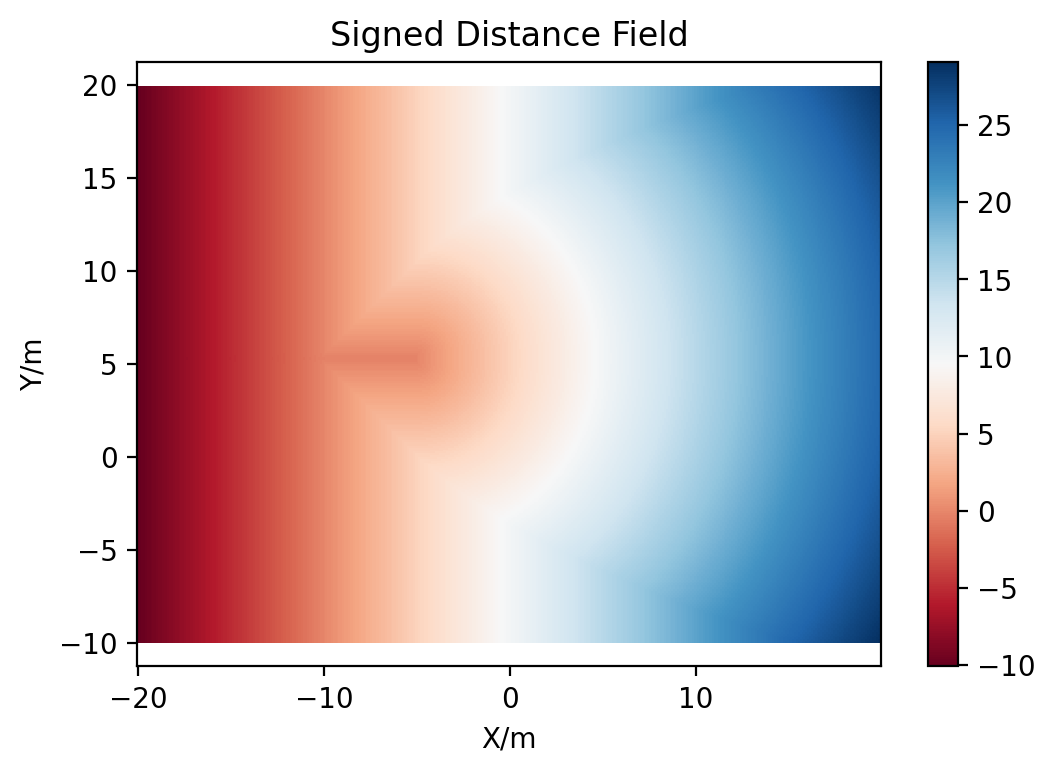

In [104]:


figure1 = plt.figure(dpi=200)
axis1 = figure1.gca()  # for 3-d, set gca(projection='3d')
plotSignedDistanceField2D(
    figure1, axis1, field, dataset.origin_x, dataset.origin_y, dataset.cell_size
)

In [105]:
## settings
total_time_sec = 10.0
total_time_step = 20
total_check_step = 50.0
delta_t = total_time_sec / total_time_step
check_inter = int(total_check_step / total_time_step - 1)

use_GP_inter = True

# point robot model
pR = PointRobot(2, 1)
spheres_data = np.asarray([0.0, 0.0, 0.0, 0.0, 0.1])
nr_body = spheres_data.shape[0]
sphere_vec = BodySphereVector()
sphere_vec.push_back(
    BodySphere(spheres_data[0], spheres_data[4], Point3(spheres_data[1:4]))
)
pR_model = PointRobotModel(pR, sphere_vec)

# GP
Qc = np.identity(2)
Qc_model = noiseModel_Gaussian.Covariance(Qc)

# Obstacle avoid settings
cost_sigma = 1
epsilon_dist = 4

# prior to start/goal
pose_fix = noiseModel_Isotropic.Sigma(2, 0.0001)
vel_fix = noiseModel_Isotropic.Sigma(2, 0.0001)

In [107]:
graph = NonlinearFactorGraph()
init_values = Values()
for i in range(0, total_time_step + 1):
    key_pos = symbol(ord("x"), i)
    key_vel = symbol(ord("v"), i)

    #% initialize as straight line in conf space
    pose = start_conf * float(total_time_step - i) / float(
        total_time_step
    ) + end_conf * i / float(total_time_step)
    vel = avg_vel
    init_values.insert(key_pos, pose)
    init_values.insert(key_vel, vel)

    #% start/end priors
    if i == 0:
        graph.push_back(PriorFactorVector(key_pos, start_conf, pose_fix))
        graph.push_back(PriorFactorVector(key_vel, start_vel, vel_fix))
    elif i == total_time_step:
        graph.push_back(PriorFactorVector(key_pos, end_conf, pose_fix))
        graph.push_back(PriorFactorVector(key_vel, end_vel, vel_fix))

    # GP priors and cost factor
    if i > 0:
        key_pos1 = symbol(ord("x"), i - 1)
        key_pos2 = symbol(ord("x"), i)
        key_vel1 = symbol(ord("v"), i - 1)
        key_vel2 = symbol(ord("v"), i)

        temp = GaussianProcessPriorLinear(
            key_pos1, key_vel1, key_pos2, key_vel2, delta_t, Qc_model
        )
        graph.push_back(temp)

        #% cost factor
        graph.push_back(
            ObstaclePlanarSDFFactorPointRobot(
                key_pos, pR_model, sdf, cost_sigma, epsilon_dist
            )
        )

        #% GP cost factor
        if use_GP_inter and check_inter > 0:
            for j in range(1, check_inter + 1):
                tau = j * (total_time_sec / total_check_step)
                graph.add(
                    ObstaclePlanarSDFFactorGPPointRobot(
                        key_pos1,
                        key_vel1,
                        key_pos2,
                        key_vel2,
                        pR_model,
                        sdf,
                        cost_sigma,
                        epsilon_dist,
                        Qc_model,
                        delta_t,
                        tau,
                    )
                )

In [108]:
parameters = DoglegParams()
optimizer = DoglegOptimizer(graph, init_values, parameters)
optimizer.optimizeSafely()
result = optimizer.values()

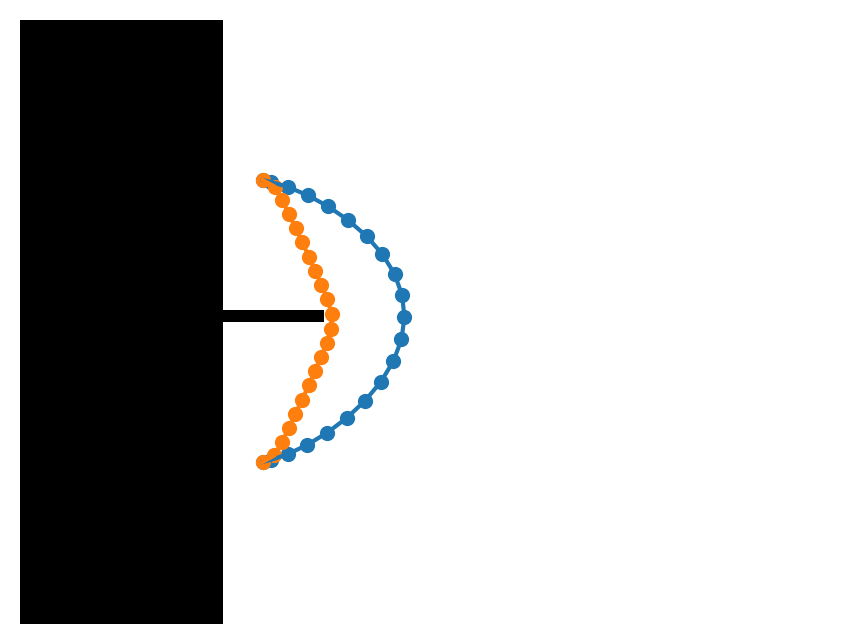

In [111]:
points = []
for i in range(total_time_step + 1):
    axis.set_title("Optimized Values")
    # plot arm
    conf = getPoint2FromValues(symbol(ord("x"), i), result)
#     plotPointRobot2D(figure, axis, pR_model, conf)
    points.append([conf.x(), conf.y()])
    # plt.pause(pause_time)
trajectory = np.array(points)

x1 = dataset.origin_x
x2 = dataset.origin_x + (dataset.cols - 1) * dataset.cell_size
y1 = dataset.origin_y
y2 = dataset.origin_y + (dataset.rows - 1) * dataset.cell_size

x, y = np.meshgrid(np.linspace(x1, x2, dataset.cols), np.linspace(y1, y2, dataset.rows))

plt.figure(dpi=200)
plt.gca().pcolormesh(x, y, 255 - dataset.map, cmap='gray', shading='auto')
plt.scatter(trajectory[:, 0], trajectory[:, 1], s=20)
plt.plot(trajectory[:, 0], trajectory[:, 1])

plt.gca().axis("off");
plt.gca().set_aspect('equal')

points = np.array([[-8.       ,  12.        ],
 [-7.4065547 , 11.675247  ],
 [-7.0324416 , 11.015581  ],
 [-6.695773  , 10.318674  ],
 [-6.362127  ,  9.611802  ],
 [-6.0296507 ,  8.90465   ],
 [-5.7010617 ,  8.190508  ],
 [-5.3810706 ,  7.485692  ],
 [-5.0750194 ,  6.7836018 ],
 [-4.7819943 ,  6.078231  ],
 [-4.5726423 ,  5.347843  ],
 [-4.590897  ,  4.6194963 ],
 [-4.822115  ,  3.888975  ],
 [-5.111192  ,  3.1937563 ],
 [-5.407861  ,  2.5009584 ],
 [-5.7165055 ,  1.8038021 ],
 [-6.039323  ,  1.0939443 ],
 [-6.3692145 ,  0.388853  ],
 [-6.699621  , -0.31173173],
 [-7.040155  , -1.0128647 ],
 [-7.410373  , -1.6739686 ],
 [-8.        , -2.        ]])
plt.scatter(points[:, 0], points[:, 1], s=20)
plt.plot(points[:, 0], points[:, 1])




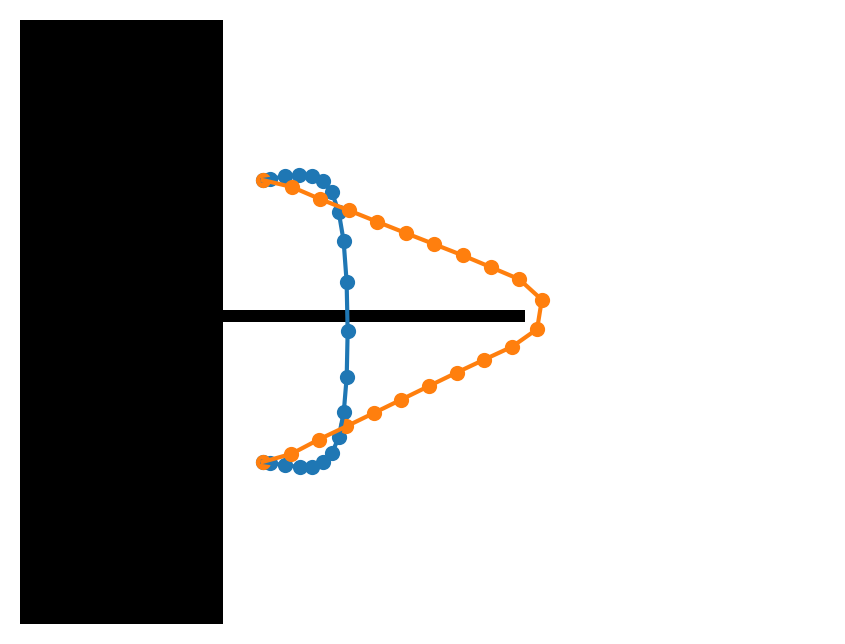

In [99]:
points = []
for i in range(total_time_step + 1):
    axis.set_title("Optimized Values")
    # plot arm
    conf = getPoint2FromValues(symbol(ord("x"), i), result)
#     plotPointRobot2D(figure, axis, pR_model, conf)
    points.append([conf.x(), conf.y()])
    # plt.pause(pause_time)
trajectory = np.array(points)

x1 = dataset.origin_x
x2 = dataset.origin_x + (dataset.cols - 1) * dataset.cell_size
y1 = dataset.origin_y
y2 = dataset.origin_y + (dataset.rows - 1) * dataset.cell_size

x, y = np.meshgrid(np.linspace(x1, x2, dataset.cols), np.linspace(y1, y2, dataset.rows))

plt.figure(dpi=200)
plt.gca().pcolormesh(x, y, 255 - dataset.map, cmap='gray', shading='auto')
plt.scatter(trajectory[:, 0], trajectory[:, 1], s=20)
plt.plot(trajectory[:, 0], trajectory[:, 1])

plt.gca().axis("off");
plt.gca().set_aspect('equal')

points = np.array([[-8.  ,       12.        ],
 [-6.543302  , 11.656584  ],
 [-5.1449814 , 11.054516  ],
 [-3.725185  , 10.498158  ],
 [-2.310743  ,  9.929336  ],
 [-0.89206463,  9.367862  ],
 [ 0.530003  ,  8.811147  ],
 [ 1.9471605 ,  8.255991  ],
 [ 3.3511205 ,  7.6664786 ],
 [ 4.7510905 ,  7.071296  ],
 [ 5.868382  ,  6.053336  ],
 [ 5.6333117 ,  4.5963044 ],
 [ 4.3917847 ,  3.72218   ],
 [ 3.008771  ,  3.0832155 ],
 [ 1.6308688 ,  2.432903  ],
 [ 0.25739324,  1.7666458 ],
 [-1.1087749 ,  1.0972962 ],
 [-2.4732227 ,  0.4303785 ],
 [-3.8398476 , -0.23416743],
 [-5.2165465 , -0.89005923],
 [-6.56571   , -1.598922  ],
 [-8.        , -2.        ]])
plt.scatter(points[:, 0], points[:, 1], s=20)
plt.plot(points[:, 0], points[:, 1])

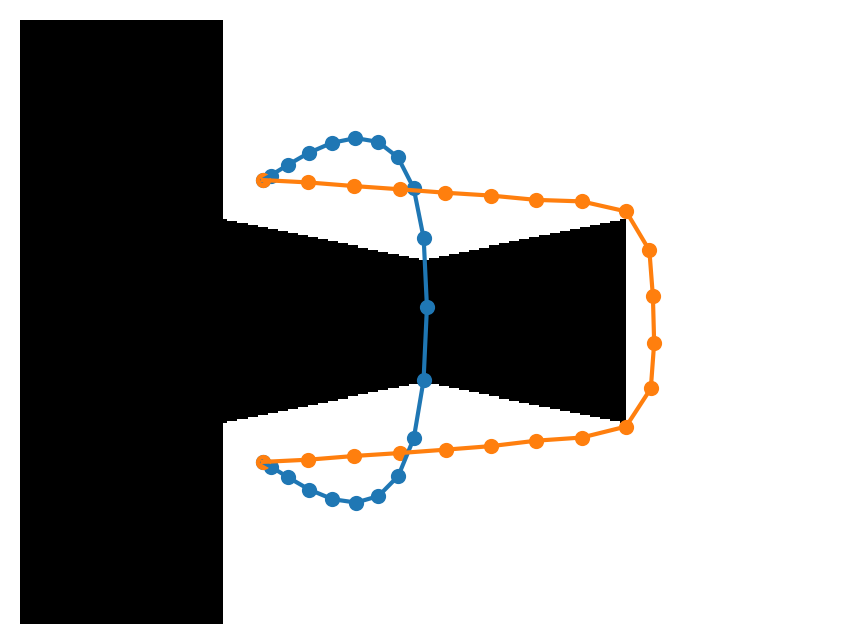

In [67]:
points = []
for i in range(total_time_step + 1):
    axis.set_title("Optimized Values")
    # plot arm
    conf = getPoint2FromValues(symbol(ord("x"), i), result)
#     plotPointRobot2D(figure, axis, pR_model, conf)
    points.append([conf.x(), conf.y()])
    # plt.pause(pause_time)
trajectory = np.array(points)

x1 = dataset.origin_x
x2 = dataset.origin_x + (dataset.cols - 1) * dataset.cell_size
y1 = dataset.origin_y
y2 = dataset.origin_y + (dataset.rows - 1) * dataset.cell_size

x, y = np.meshgrid(np.linspace(x1, x2, dataset.cols), np.linspace(y1, y2, dataset.rows))

plt.figure(dpi=200)
plt.gca().pcolormesh(x, y, 255 - dataset.map, cmap='gray', shading='auto')
plt.scatter(trajectory[:, 0], trajectory[:, 1], s=20)
plt.plot(trajectory[:, 0], trajectory[:, 1])

plt.gca().axis("off");
plt.gca().set_aspect('equal')

points = np.array([[-8.,         12.        ],
 [-5.7314653,  11.881608  ],
 [-3.4524329,  11.701319  ],
 [-1.1804763,  11.542024  ],
 [ 1.0789251,  11.370574  ],
 [ 3.339159 ,  11.229115  ],
 [ 5.5930433,  11.014684  ],
 [ 7.8553696,  10.940255  ],
 [10.056276 ,  10.4413595 ],
 [11.210006 ,   8.507132  ],
 [11.3857765,   6.217959  ],
 [11.44803  ,   3.9123356 ],
 [11.282219 ,   1.6472638 ],
 [10.051938 ,  -0.24207655],
 [ 7.8554697,  -0.7883848 ],
 [ 5.59683  ,  -0.9444567 ],
 [ 3.34887  ,  -1.2143525 ],
 [ 1.0898356,  -1.390593  ],
 [-1.1703094,  -1.5577848 ],
 [-3.4359682,  -1.7036059 ],
 [-5.722002 ,  -1.8884432 ],
 [-8.       ,  -2.        ]])
plt.scatter(points[:, 0], points[:, 1], s=20)
plt.plot(points[:, 0], points[:, 1])

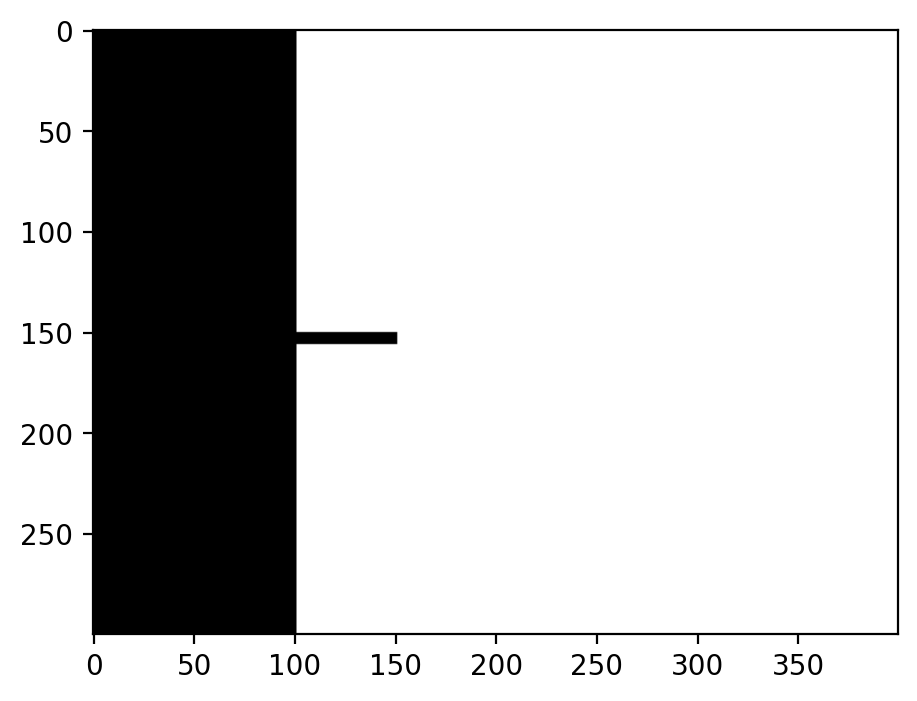

In [102]:
plt.figure(dpi=200)



dataset = Dataset()
dataset.cols = 400  # x
dataset.rows = 300  # y
dataset.origin_x = -20
dataset.origin_y = -10
dataset.cell_size = 0.1

grid_corner_x = dataset.origin_x + (dataset.cols - 1) * dataset.cell_size
grid_corner_y = dataset.origin_y + (dataset.rows - 1) * dataset.cell_size
    
# axis = plt.gca()
# axis.axis("equal")
# axis.axis(
#     [
#         dataset.origin_x - dataset.cell_size / 2,
#         grid_corner_x + dataset.cell_size / 2,
#         dataset.origin_y - dataset.cell_size / 2,
#         grid_corner_y + dataset.cell_size / 2,
#     ]
# )

dataset.map = np.zeros((dataset.rows, dataset.cols))
draw_poly(np.array([[-20, -10], [-20, 20], [-10, 20], [-10, -10]]), dataset)
# draw_poly(np.array([[-10, 5], [5, 5], [5, 5.5], [-10, 5.5]]), dataset)
draw_poly(np.array([[-10, 5], [-5, 5], [-5, 5.5], [-10, 5.5]]), dataset)
plt.imshow(255 - dataset.map, cmap="gray")